# Sentiment Analysis with Glove x Deep Bi-LSTM 

## Setup

In [15]:
# Check GPU
!nvidia-smi

Sun May 22 05:40:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |    266MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf

tfds.disable_progress_bar()

The IMDB large movie review dataset is a *binary classification* dataset — all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [17]:
# Load data 
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [18]:
# Dataset = Text (string) + Label (int)
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

[The print of string constant is always attached with 'b' inTensorFlow?](https://stackoverflow.com/questions/40904979/the-print-of-string-constant-is-always-attached-with-b-intensorflow)


Initially this returns a dataset of (text, label pairs):

To perform efficient batching for the potentially large number of training examples, use the `tf.data.Dataset API`. After this step, you would have a `tf.data.Dataset` object of (target_word, context_word), (label) elements to train. Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [19]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [20]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
# Each batch pair (text, label) mix by 64 pairs
for example, label in train_dataset.take(1):
  print('Texts: ', example.numpy()[:3])
  print('Labels: ', label.numpy()[:3])

Texts:  [b'Time for a rant, eh: I thought Spirit was a great movie to watch. However, there were a few things that stop me from rating it higher than a 6 or 7 (I\'m being a little bit generous with the 7).<br /><br />Point #1: Matt Damon aggravates me. I was thinking, \'what a dicky voice they got for the main character,\' when I first heard him narrate - and then I realized it is Matt Damon. The man bugs me so very bad - his performance in "The Departed" was terrible and ruined the movie for me (before the movie got a chance to ruin itself, but that\'s another story for some other time), as it almost did "Spirit". I was able to get past this fact because of how little narration there actually was... thankfully.<br /><br />Point #2: Brian Adams sucks... The whole score was terrible... The songs were unoriginal, generic, and poorly executed; not once did I find the music to fit; and the lyrics were terrible. Every time one of the lame songs came on, I was turned off. I almost thought I\

## Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [22]:
# Size of vocab (dim each word before pass Embedding Layer)
VOCAB_SIZE = 10000
# Max length of sentences 
max_length = 250
# Embedding Layer Dim: Aim covert large dim to small dim
embedding_dim = 100

In [23]:
encoder = tf.keras.layers.TextVectorization(VOCAB_SIZE)

# Adapt TextVectorization for train text to build vocab
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 10 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [24]:
vocab = np.array(encoder.get_vocabulary())
vocab[:10]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it'],
      dtype='<U17')

Once the vocabulary is set, the layer can encode text into indices. The tensors of **indices are 0-padded to the longest sequence in the batch** (unless you set a fixed `output_sequence_length`):

In [25]:
# Width of list = size of longest sequence choose from batch
encoded_example = encoder(example)[:3].numpy()
encoded_example.shape

(3, 857)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [26]:
print("Original: ", example[1].numpy())
print("Round-trip: ", " ".join(vocab[encoded_example[1]]))

Original:  b'When I go out to the video store to rent a flick I usually trust IMDb\'s views on a film and, until this one, had never seen a flick rated 7.0 or above on the site I did not enjoy.<br /><br />Sidney Lumet, a legendary director of some of the best films of the 20th century, really misstepped here by making one of the biggest mistakes a filmmaker can: filling a film\'s cast with thoroughly unlikeable characters with no real redeeming qualities whatsoever.<br /><br />I like films with flawed characters, but no matter how dark someone\'s personality is we all have a bit of light in there too, we\'re all shades of gray with some darker or brighter than others. Mr. Lumet crossed this line by filling this movie with totally unsympathetic and almost masochistic pitch-black characters.<br /><br />Ethan Hawke\'s Hank is a 30-something whining, immature, irresponsible man-child divorced from a marriage with a wife that hates him and a daughter who thinks he\'s a loser, which he very 

## GloVec 

In [27]:
# Download Pretrain GloVec
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-05-22 05:40:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-22 05:40:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-22 05:40:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones.

[split with max split = 1](https://www.w3schools.com/python/ref_string_split.asp)

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [28]:
# Load file with path 
embeddings_index = {}
with open("/content/glove.6B.100d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [29]:
# Check embedding of words 
embeddings_index["scored"]

array([ 0.20988  , -0.47655  ,  0.28336  , -0.81891  ,  0.69712  ,
        0.60576  ,  0.70267  , -0.37126  , -1.2579   , -0.15087  ,
        0.8627   , -1.0148   , -1.1333   , -0.35162  ,  0.59548  ,
        0.18641  , -0.42956  ,  0.87956  , -0.79354  , -0.11465  ,
        0.93346  ,  0.25379  ,  0.37372  ,  0.58551  ,  0.64899  ,
       -0.41579  , -0.68475  ,  0.33655  ,  0.0084698, -0.52282  ,
       -0.88602  ,  1.1002   ,  0.21214  ,  0.6451   ,  0.72751  ,
       -0.92499  , -0.16333  ,  1.3088   , -1.5823   ,  0.51023  ,
        0.25315  , -0.33866  ,  0.33079  ,  0.0080323,  0.34725  ,
        0.13952  ,  0.38958  , -0.98305  ,  0.46568  , -0.089045 ,
       -0.37794  , -0.049653 , -1.1755   ,  0.73942  , -0.36438  ,
       -2.4471   , -0.75071  ,  0.0901   , -0.32032  ,  1.4176   ,
       -0.69838  ,  0.069092 , -0.779    ,  0.55792  , -0.374    ,
        0.097131 ,  0.098289 ,  0.50688  , -0.8024   ,  0.45312  ,
       -0.43216  ,  0.19852  ,  0.66294  , -0.16279  ,  0.7524

Now, let's prepare a corresponding embedding matrix that we can use in a Keras `Embedding` layer. It's a simple NumPy matrix where entry at index `i` is the pre-trained vector for the word of index `i` in our `vectorizer`'s vocabulary.

In [30]:
voc = encoder.get_vocabulary()
# Assign index with word to dict 
word_index = dict(zip(voc, range(VOCAB_SIZE)))

In [31]:
hits = 0        # Word can converted
misses = 0      # Word can't converted (OOV)

# Prepare embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[index] = embedding_vector
        hits += 1
    else:
        misses += 1

# Check acc
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9691 words (309 misses)


Next, we load the pre-trained word embeddings matrix into an `Embedding` layer.

Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to update them during training).

In [32]:
# Check train dataset
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [33]:
model_glovec = tf.keras.Sequential([
    # Must have add "encoder" layers to convert data from string (None,) to sequence
    encoder,
    # Embedding
    tf.keras.layers.Embedding(VOCAB_SIZE,
                    embedding_dim,
                    input_length= max_length,
                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                    trainable= False),
    # Bidirectional LSTM 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25)),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation = "sigmoid")])

model_glovec.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 100)        60400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50)               25200     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                        

`text_vectorization_1` has Output shape (None, None)
* `None` 1 meaning batch size in feed & backward 
* `None` 2 meaning size of length text (after this layer will convert to sequences)

In [34]:
# Resets all state generated by Keras
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [35]:
# Compile & Fit model 
model_glovec.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics='acc')

# Callbacks 
tensorboard_callback_glove = tf.keras.callbacks.TensorBoard(log_dir="logs")

history = model_glovec.fit(train_dataset, epochs= 30,
                    validation_data = test_dataset,
                    validation_steps = 30,
                    callbacks=[tensorboard_callback_glove])

Epoch 1/30
391/391 [==============================] - 58s 121ms/step - loss: 0.6506 - acc: 0.6230 - val_loss: 0.5836 - val_acc: 0.7115
Epoch 2/30
391/391 [==============================] - 46s 117ms/step - loss: 0.6635 - acc: 0.6125 - val_loss: 0.5998 - val_acc: 0.6885
Epoch 3/30
391/391 [==============================] - 47s 118ms/step - loss: 0.6058 - acc: 0.6814 - val_loss: 0.7645 - val_acc: 0.4984
Epoch 4/30
391/391 [==============================] - 46s 117ms/step - loss: 0.6026 - acc: 0.6756 - val_loss: 0.5481 - val_acc: 0.7323
Epoch 5/30
391/391 [==============================] - 47s 119ms/step - loss: 0.5559 - acc: 0.7222 - val_loss: 0.5337 - val_acc: 0.7469
Epoch 6/30
391/391 [==============================] - 47s 119ms/step - loss: 0.6583 - acc: 0.6228 - val_loss: 0.6835 - val_acc: 0.6016
Epoch 7/30
391/391 [==============================] - 46s 117ms/step - loss: 0.6759 - acc: 0.6112 - val_loss: 0.6655 - val_acc: 0.6203
Epoch 8/30
391/391 [==============================] - 4

In [44]:
# Evaluation 
model_glovec.evaluate(test_dataset)

391/391 [==============================] - 27s 66ms/step - loss: 0.3728 - acc: 0.8407


[0.37279191613197327, 0.8406800031661987]

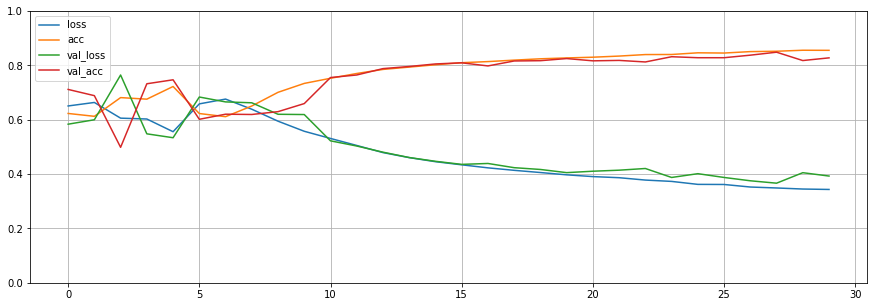

In [45]:
# Visualization
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1);

## Deep Bi-LSTM

### Bi-LSTM


![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


### Deep Bi-LSTM

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://www.tensorflow.org/text/tutorials/images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [46]:
model_dbilstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim = 100,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # Bidirectional LSTM 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25)),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation = "sigmoid")])

model_dbilstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 100)        60400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50)               25200     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                        

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [47]:
# Check masking layers
[layer.supports_masking for layer in model_dbilstm.layers]

[False, True, True, True, True, True]

To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [48]:
# Predict on a sample text without padding.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Prediction
model_dbilstm.predict(np.array([sample_text]))

array([[0.50011927]], dtype=float32)

Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [49]:
# Predict on a sample text with padding
padding = "the " * 2000
model_dbilstm.predict(np.array([sample_text, padding]))

array([[0.50011927],
       [0.5011725 ]], dtype=float32)

Compile the Keras model to configure the training process:

In [50]:
# Resets all state generated by Keras
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
# Compile the model 
model_dbilstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics='acc')

# Train the model 
history_dbilstm = model_dbilstm.fit(train_dataset, epochs= 30,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/30
391/391 [==============================] - 122s 276ms/step - loss: 0.5661 - acc: 0.7025 - val_loss: 0.3699 - val_acc: 0.8495
Epoch 2/30
391/391 [==============================] - 53s 134ms/step - loss: 0.2705 - acc: 0.8962 - val_loss: 0.2991 - val_acc: 0.8776
Epoch 3/30
391/391 [==============================] - 53s 134ms/step - loss: 0.1975 - acc: 0.9302 - val_loss: 0.3051 - val_acc: 0.8797
Epoch 4/30
391/391 [==============================] - 54s 135ms/step - loss: 0.1482 - acc: 0.9513 - val_loss: 0.3384 - val_acc: 0.8724
Epoch 5/30
391/391 [==============================] - 53s 135ms/step - loss: 0.1156 - acc: 0.9644 - val_loss: 0.3906 - val_acc: 0.8687
Epoch 6/30
391/391 [==============================] - 54s 136ms/step - loss: 0.0977 - acc: 0.9718 - val_loss: 0.4703 - val_acc: 0.8443
Epoch 7/30
391/391 [==============================] - 53s 135ms/step - loss: 0.0784 - acc: 0.9789 - val_loss: 0.4797 - val_acc: 0.8589
Epoch 8/30
391/391 [==============================] - 

In [54]:
# Evaluation
test_loss, test_acc = model_dbilstm.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 33s 83ms/step - loss: 0.6734 - acc: 0.8551
Test Loss: 0.6733571290969849
Test Accuracy: 0.8551200032234192


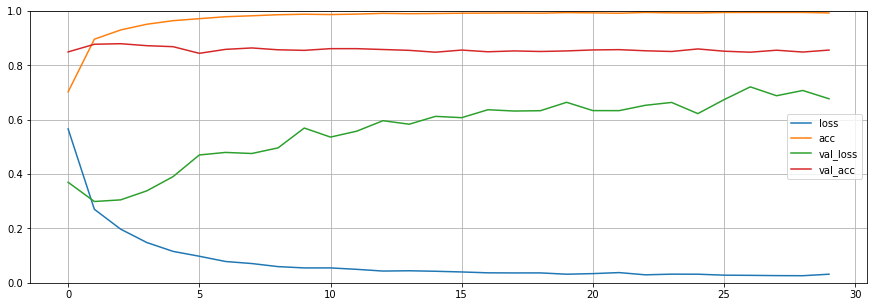

In [55]:
# Visualization
import matplotlib.pyplot as plt

pd.DataFrame(history_dbilstm.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1);

Run a prediction on a new sentence

If the prediction is >= 0.0, it is positive else it is negative.

In [53]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

model_dbilstm.predict(np.array([sample_text]))

array([[0.9825287]], dtype=float32)